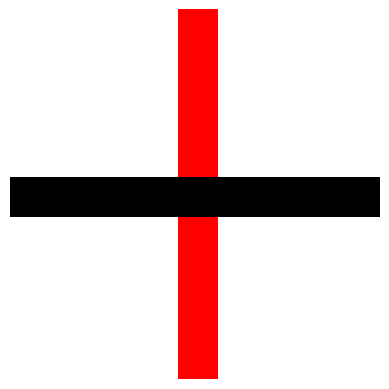

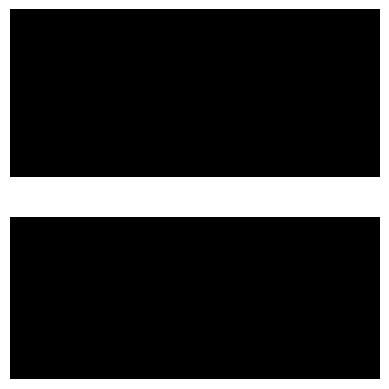

<ipython-input-29-29d3ae5da2c2>:14: RuntimeWarning: overflow encountered in ubyte_scalars
  delta_T = abs(T[i1, j1] - T[i2, j2])
<ipython-input-29-29d3ae5da2c2>:20: RuntimeWarning: overflow encountered in ubyte_scalars
  return min(s, T[i1, j1] + delta_T, T[i2, j2] + delta_T)
<ipython-input-29-29d3ae5da2c2>:61: RuntimeWarning: overflow encountered in ubyte_scalars
  image[x + 1, y, z] - image[x - 1, y, z],
<ipython-input-29-29d3ae5da2c2>:39: RuntimeWarning: invalid value encountered in double_scalars
  dir = (dot_gradt_r) / np.linalg.norm(r,1)
<ipython-input-29-29d3ae5da2c2>:42: RuntimeWarning: divide by zero encountered in double_scalars
  dst = 1 / (np.linalg.norm(r,1) ** 2)
<ipython-input-29-29d3ae5da2c2>:62: RuntimeWarning: overflow encountered in ubyte_scalars
  image[x, y + 1, z] - image[x, y - 1, z],


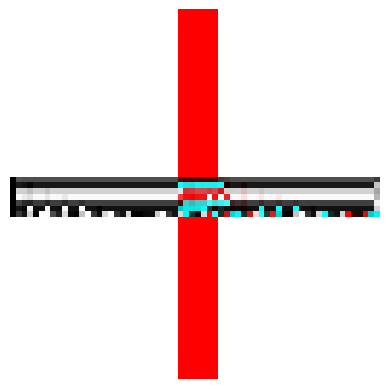

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
EPS = 1e-6

def solve(i1, j1, i2, j2, T):

    if T[i1, j1] == 1000000 and T[i2, j2] == 1000000:

        return 100000


    delta_T = abs(T[i1, j1] - T[i2, j2])


    s = min(T[i1, j1], T[i2, j2]) + 1.0


    return min(s, T[i1, j1] + delta_T, T[i2, j2] + delta_T)
def gradient(array):
    gradient_x = np.gradient(array, axis=0)
    gradient_y = np.gradient(array, axis=1)
    return gradient_x, gradient_y



def inpaint(i, j, T, image, B=1):
    s = 0
    Ia = np.zeros(3)
    grad_T = np.gradient(T)

    for x in range(i - B, i + B + 1):
        for y in range(j - B, j + B + 1):
            for z in range(3):
                if x - 1 >= 0 and y - 1 >= 0 and T[x - 1, y - 1] == 0:
                    r = np.array([x- i, y - j])
                    dot_gradt_r = (grad_T[0][i, j] * r[0]) + (grad_T[1][i, j] * r[1])
                    dir = (dot_gradt_r) / np.linalg.norm(r,1)
                    if dir==0:
                      dir = EPS
                    dst = 1 / (np.linalg.norm(r,1) ** 2)

                    lev = 1 / (1 + np.abs(T[x-1,y-1] - T[i, j]))

                    w = abs(dir * dst * lev)


                    if (
                        x + 1 < image.shape[0]
                        and y + 1 < image.shape[1]
                        and x - 1 >= 0
                        and y - 1 >= 0
                        and T[x + 1, y] == 0
                        and T[x - 1, y] == 0
                        and T[x, y + 1] == 0
                        and T[x, y - 1] == 0
                    ):
                        gradI = np.array(
                            [
                                image[x + 1, y, z] - image[x - 1, y, z],
                                image[x, y + 1, z] - image[x, y - 1, z],
                            ]
                        )
                        dot_gradi_r = (gradI[0] * r[0]) + (gradI[1] * r[1])
                        Ia[z] += w * (image[x, y, z] + dot_gradi_r)
                        s += w

    for z in range(3):
        if s != 0:
            image[i, j, z] = Ia[z] / s
        else:
            image[i, j, z] = 0



narrow_band=[]
image_width = 64
image_height = 64
image = np.ones((image_height, image_width, 3), dtype=np.uint8) * 255
start_point = (image_width // 2, 0)
end_point = (image_width // 2, image_height)
image = cv2.line(image, start_point, end_point, (255,0,0), 5)
start_point = (0, image_height // 2)
end_point = (image_width, image_height // 2)
image = cv2.line(image, start_point, end_point, (0,0,0),5)
plt.imshow(image)
plt.axis('off')
plt.show()
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
T=np.zeros_like(gray_image)
for i in range(0,image.shape[0]):
  for j in range(0,image.shape[1]):
    if any(image[i,j]!=(0,0,0)):
      T[i,j]=0
      narrow_band.append([i,j])
    else:
      T[i,j]=10000
      narrow_band.append([i,j])
plt.imshow(T,cmap='gray')
plt.axis('off')
plt.show()


while narrow_band:
    min_distance = 1000000
    min_point = None
    for point in narrow_band:

        if T[point[0],point[1]]<min_distance:
            min_distance = T[point[0],point[1]]
            min_point = point

    current_point = min_point

    if current_point is None:
        break

    narrow_band.remove(current_point)

    neighbors = [
        (current_point[0] - 1, current_point[1]),
        (current_point[0] + 1, current_point[1]),
        (current_point[0], current_point[1] - 1),
        (current_point[0], current_point[1] + 1),
    ]

    for neighbor in neighbors:

        if 0 <= neighbor[0] < image.shape[0] and 0 <= neighbor[1] < image.shape[1]:
            new_distance = solve(current_point[0], current_point[1], neighbor[0], neighbor[1],T)

            if new_distance < T[neighbor]:
                T[neighbor] = new_distance


                if neighbor not in narrow_band:
                    narrow_band.append(neighbor)


                    inpaint(neighbor[0],neighbor[1],T,image)


plt.imshow(image,cmap='gray')
plt.axis('off')
plt.show()



